<a href="https://colab.research.google.com/github/asadimtiazmalik/Pix2Pix-GAN/blob/main/Pix2PixGAN_Satelitte_Image_to_Maps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
  # pix2pix gan for satellite to map image-to-image translation
from numpy import load
from numpy import zeros
from numpy import ones
from numpy.random import randint
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.models import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from matplotlib import pyplot

# load, split and scale the maps dataset ready for training
from os import listdir
from numpy import asarray
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from numpy import savez_compressed


In [ ]:
!tar -xvf '/content/drive/MyDrive/maps.tar.gz'

maps/
maps/train/
maps/train/1.jpg
maps/train/10.jpg
maps/train/100.jpg
maps/train/1000.jpg
maps/train/1001.jpg
maps/train/1002.jpg
maps/train/1003.jpg
maps/train/1004.jpg
maps/train/1005.jpg
maps/train/1006.jpg
maps/train/1007.jpg
maps/train/1008.jpg
maps/train/1009.jpg
maps/train/101.jpg
maps/train/1010.jpg
maps/train/1011.jpg
maps/train/1012.jpg
maps/train/1013.jpg
maps/train/1014.jpg
maps/train/1015.jpg
maps/train/530.jpg
maps/train/531.jpg
maps/train/532.jpg
maps/train/533.jpg
maps/train/534.jpg
maps/train/535.jpg
maps/train/536.jpg
maps/train/537.jpg
maps/train/538.jpg
maps/train/539.jpg
maps/train/54.jpg
maps/train/540.jpg
maps/train/541.jpg
maps/train/542.jpg
maps/train/543.jpg
maps/train/544.jpg
maps/train/545.jpg
maps/train/546.jpg
maps/train/547.jpg
maps/train/548.jpg
maps/train/549.jpg
maps/train/55.jpg
maps/train/550.jpg
maps/train/551.jpg
maps/train/552.jpg
maps/train/553.jpg
maps/train/554.jpg
maps/train/555.jpg
maps/train/556.jpg
maps/train/557.jpg
maps/train/558.jpg
ma

In [ ]:
# load all images in a directory into memory
def load_images(path, size=(256,512)):
  src_list, tar_list = list(), list()
  # enumerate filenames in directory, assume all are images
  for filename in listdir(path):
    # load and resize the image
    pixels = load_img(path + filename, target_size=size)
    # convert to numpy array
    pixels = img_to_array(pixels)
    # split into satellite and map
    sat_img, map_img = pixels[:, :256], pixels[:, 256:]
    src_list.append(sat_img)
    tar_list.append(map_img)
  return [asarray(src_list), asarray(tar_list)]

# dataset path
path = 'maps/train/'
# load dataset
[src_images, tar_images] = load_images(path)
print('Loaded: ', src_images.shape, tar_images.shape)
# save as compressed numpy array
filename = 'maps_256.npz'
savez_compressed(filename, src_images, tar_images)
print('Saved dataset: ', filename)


Loaded:  (1096, 256, 256, 3) (1096, 256, 256, 3)
Saved dataset:  maps_256.npz


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# define the discriminator model
def define_discriminator(image_shape):
  # weight initialization
  init = RandomNormal(stddev=0.02)
  # source image input
  in_src_image = Input(shape=image_shape)
  # target image input
  in_target_image = Input(shape=image_shape)
  # concatenate images channel-wise
  merged = Concatenate()([in_src_image, in_target_image])
  # C64
  d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
  d = LeakyReLU(alpha=0.2)(d)
  # C128
  d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
  d = BatchNormalization()(d)
  d = LeakyReLU(alpha=0.2)(d)
  # C256
  d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
  d = BatchNormalization()(d)
  d = LeakyReLU(alpha=0.2)(d)
  # C512
  d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
  d = BatchNormalization()(d)
  d = LeakyReLU(alpha=0.2)(d)
  # second last output layer
  d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
  d = BatchNormalization()(d)
  d = LeakyReLU(alpha=0.2)(d)
  # patch output
  d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
  patch_out = Activation('sigmoid')(d)
  # define model
  model = Model([in_src_image, in_target_image], patch_out)
  # compile model
  opt = Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
  return model

In [ ]:
# define an encoder block
def define_encoder_block(layer_in, n_filters, batchnorm=True):
  # weight initialization
  init = RandomNormal(stddev=0.02)
  # add downsampling layer
  g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same',
  kernel_initializer=init)(layer_in)
  # conditionally add batch normalization
  if batchnorm:
    g = BatchNormalization()(g, training=True)
  # leaky relu activation
  g = LeakyReLU(alpha=0.2)(g)
  return g

# define a decoder block
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
  # weight initialization
  init = RandomNormal(stddev=0.02)
  # add upsampling layer
  g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same',
  kernel_initializer=init)(layer_in)
  # add batch normalization
  g = BatchNormalization()(g, training=True)
  # conditionally add dropout
  if dropout:
    g = Dropout(0.5)(g, training=True)
  # merge with skip connection
  g = Concatenate()([g, skip_in])
  # relu activation
  g = Activation('relu')(g)
  return g



In [ ]:
# define the standalone generator model
def define_generator(image_shape=(256,256,3)):
  # weight initialization
  init = RandomNormal(stddev=0.02)
  # image input
  in_image = Input(shape=image_shape)
  # encoder model
  e1 = define_encoder_block(in_image, 64, batchnorm=False)
  e2 = define_encoder_block(e1, 128)
  e3 = define_encoder_block(e2, 256)
  e4 = define_encoder_block(e3, 512)
  e5 = define_encoder_block(e4, 512)
  e6 = define_encoder_block(e5, 512)
  e7 = define_encoder_block(e6, 512)
  # bottleneck, no batch norm and relu
  b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
  b = Activation('relu')(b)
  # decoder model
  d1 = decoder_block(b, e7, 512)
  d2 = decoder_block(d1, e6, 512)
  d3 = decoder_block(d2, e5, 512)
  d4 = decoder_block(d3, e4, 512, dropout=False)
  d5 = decoder_block(d4, e3, 256, dropout=False)
  d6 = decoder_block(d5, e2, 128, dropout=False)
  d7 = decoder_block(d6, e1, 64, dropout=False)
  # output
  g = Conv2DTranspose(3, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7)
  out_image = Activation('tanh')(g)
  # define model
  model = Model(in_image, out_image)
  return model


In [ ]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model, image_shape):
  # make weights in the discriminator not trainable
  d_model.trainable = False
  # define the source image
  in_src = Input(shape=image_shape)
  # connect the source image to the generator input
  gen_out = g_model(in_src)
  # connect the source input and generator output to the discriminator input
  dis_out = d_model([in_src, gen_out])
  # src image as input, generated image and classification output
  model = Model(in_src, [dis_out, gen_out])
  # compile model
  opt = Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt, loss_weights=[1,100])
  return model


In [ ]:
# load and prepare training images
def load_real_samples(filename):
  # load the compressed arrays
  data = load(filename)
  # unpack the arrays
  X1, X2 = data['arr_0'], data['arr_1']
  # scale from [0,255] to [-1,1]
  X1 = (X1 - 127.5) / 127.5
  X2 = (X2 - 127.5) / 127.5
  return [X1, X2]


In [ ]:
# GAN Hacks List from Sumit Chintalas Paper Laplasian GANs 

# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples, patch_shape):
  # unpack dataset
  trainA, trainB = dataset
  # choose random instances
  ix = randint(0, trainA.shape[0], n_samples)
  # retrieve selected images
  X1, X2 = trainA[ix], trainB[ix]
  # generate 'real' class labels (1)
  y = ones((n_samples, patch_shape, patch_shape, 1))
  return [X1, X2], y

# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, samples, patch_shape):
  # generate fake instance
  X = g_model.predict(samples)
  # create 'fake' class labels (0)
  y = zeros((len(X), patch_shape, patch_shape, 1))
  return X, y

In [ ]:
# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, dataset, n_samples=3):
  # select a sample of input images
  [X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)
  # generate a batch of fake samples
  X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
  # scale all pixels from [-1,1] to [0,1]
  X_realA = (X_realA + 1) / 2.0
  X_realB = (X_realB + 1) / 2.0
  X_fakeB = (X_fakeB + 1) / 2.0
  # plot real source images
  for i in range(n_samples):
    pyplot.subplot(3, n_samples, 1 + i)
    pyplot.axis('off')
    pyplot.imshow(X_realA[i])
  # plot generated target image
  for i in range(n_samples):
    pyplot.subplot(3, n_samples, 1 + n_samples + i)
    pyplot.axis('off')
    pyplot.imshow(X_fakeB[i])
  # plot real target image
  for i in range(n_samples):
    pyplot.subplot(3, n_samples, 1 + n_samples*2 + i)
    pyplot.axis('off')
    pyplot.imshow(X_realB[i])
  # save plot to file
  filename1 = 'plot_%06d.png' % (step+1)
  pyplot.savefig(filename1)
  pyplot.close()
  # save the generator model
  filename2 = 'model_%06d.h5' % (step+1)
  g_model.save(filename2)
  print('>Saved: %s and %s' % (filename1, filename2))

In [ ]:
# train pix2pix models
def train(d_model, g_model, gan_model, dataset, n_epochs=25, n_batch=1):
  # determine the output square shape of the discriminator
  n_patch = d_model.output_shape[1]
  # unpack dataset
  trainA, trainB = dataset
  # calculate the number of batches per training epoch
  bat_per_epo = int(len(trainA) / n_batch)
  # calculate the number of training iterations
  n_steps = bat_per_epo * n_epochs
  # manually enumerate epochs
  for i in range(n_steps):
    # select a batch of real samples
    [X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
    # generate a batch of fake samples
    X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
    # update discriminator for real samples
    d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
    # update discriminator for generated samples
    d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
    # update the generator
    g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
    # summarize performance
    print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))
    # summarize model performance
    if (i+1) % (bat_per_epo * 10) == 0:
      summarize_performance(i, g_model, dataset)

In [ ]:
# load image data
dataset = load_real_samples('maps_256.npz')
print('Loaded', dataset[0].shape, dataset[1].shape)
# define input shape based on the loaded dataset
image_shape = dataset[0].shape[1:]
# define the models
d_model = define_discriminator(image_shape)
g_model = define_generator(image_shape)
# define the composite model
gan_model = define_gan(g_model, d_model, image_shape)
# train model
train(d_model, g_model, gan_model, dataset)

Streaming output truncated to the last 5000 lines.
>22401, d1[0.000] d2[0.000] g[4.434]
>22402, d1[0.000] d2[0.000] g[5.679]
>22403, d1[0.000] d2[0.001] g[8.889]
>22404, d1[0.000] d2[0.001] g[5.877]
>22405, d1[0.000] d2[0.002] g[6.029]
>22406, d1[0.000] d2[0.000] g[6.066]
>22407, d1[0.000] d2[0.001] g[4.500]
>22408, d1[0.000] d2[0.000] g[5.811]
>22409, d1[0.000] d2[0.000] g[1.696]
>22410, d1[0.000] d2[0.000] g[9.014]
>22411, d1[0.000] d2[0.001] g[5.619]
>22412, d1[0.001] d2[0.001] g[4.852]
>22413, d1[0.000] d2[0.005] g[7.261]
>22414, d1[0.000] d2[0.000] g[6.314]
>22415, d1[0.000] d2[0.000] g[3.783]
>22416, d1[0.000] d2[0.000] g[4.733]
>22417, d1[0.000] d2[0.000] g[5.217]
>22418, d1[0.000] d2[0.000] g[5.190]
>22419, d1[0.000] d2[0.001] g[6.124]
>22420, d1[0.000] d2[0.009] g[5.493]
>22421, d1[0.001] d2[0.001] g[5.014]
>22422, d1[0.000] d2[0.000] g[5.899]
>22423, d1[0.000] d2[0.000] g[3.990]
>22424, d1[0.001] d2[0.003] g[7.821]
>22425, d1[0.002] d2[0.001] g[8.113]
>22426, d1[0.001] d2[0.0

Loaded (1096, 256, 256, 3) (1096, 256, 256, 3)


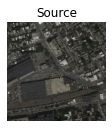

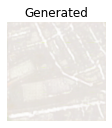

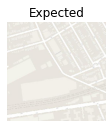

In [ ]:
from keras.models import load_model
from numpy import load
from numpy import vstack
from matplotlib import pyplot
from numpy.random import randint

# load and prepare training images
def load_real_samples(filename):
  # load the compressed arrays
  data = load(filename)
  # unpack the arrays
  X1, X2 = data['arr_0'], data['arr_1']
  # scale from [0,255] to [-1,1]
  X1 = (X1 - 127.5) / 127.5
  X2 = (X2 - 127.5) / 127.5
  return [X1, X2]

# plot source, generated and target images
def plot_images(src_img, gen_img, tar_img):
  images = vstack((src_img, gen_img, tar_img))
  # scale from [-1,1] to [0,1]
  images = (images + 1) / 2.0
  titles = ['Source', 'Generated', 'Expected']
  # plot images row by row
  for i in range(len(images)):
    # define subplot
    pyplot.subplot(1, 3, 1 + i)
    # turn off axis
    pyplot.axis('off')
    # plot raw pixel data 
    pyplot.imshow(images[i])
    # show title
    pyplot.title(titles[i])
    pyplot.show()

# load dataset
[X1, X2] = load_real_samples('maps_256.npz')
print('Loaded', X1.shape, X2.shape)

# load model
model = load_model('model_021920.h5')

ix = randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix]

gen_image = model.predict(src_image)
plot_images(src_image, gen_image, tar_image)

In [ ]:
!mkdir -p my_model
model = load_model('model_021920.h5')
model.save('my_model/model_1')

INFO:tensorflow:Assets written to: my_model/model_1/assets


In [ ]:
model = load_model('my_model/model_1')
